In [1]:
print("all ok")

all ok


In [62]:
import sys, os

# Get project root — one level up from 'research_and_analyst'
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print("Project root added to path:", project_root)

Project root added to path: c:\learning\LLMOps


In [2]:
from research_and_analysis.utils.model_loader import ModelLoader

In [3]:
model_loader = ModelLoader()

{"timestamp": "2026-02-13T05:09:18.353000Z", "level": "info", "event": "OPENAI_API_KEY loaded from environment"}
{"timestamp": "2026-02-13T05:09:18.355184Z", "level": "info", "event": "GOOGLE_API_KEY loaded from environment"}
{"timestamp": "2026-02-13T05:09:18.356752Z", "level": "info", "event": "GROQ_API_KEY loaded from environment"}
{"timestamp": "2026-02-13T05:09:18.358533Z", "level": "warning", "event": "ASTRA_DB_API_ENDPOINT is missing from environment"}
{"timestamp": "2026-02-13T05:09:18.359542Z", "level": "warning", "event": "ASTRA_DB_APPLICATION_TOKEN is missing from environment"}
{"timestamp": "2026-02-13T05:09:18.360542Z", "level": "warning", "event": "ASTRA_DB_KEYSPACE is missing from environment"}
{"config_keys": ["astra_db", "embedding_model", "retriever", "llm"], "timestamp": "2026-02-13T05:09:18.364587Z", "level": "info", "event": "YAML config loaded"}


In [4]:
llm=model_loader.load_llm()

{"provider": "openai", "model": "gpt-4o", "timestamp": "2026-02-13T05:09:21.020635Z", "level": "info", "event": "Loading LLM"}


In [5]:
llm.invoke("hi").content

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'Hello! How can I assist you today?'

In [6]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [7]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage,HumanMessage , SystemMessage
from langgraph.checkpoint.memory import MemorySaver

### PYDANTIC MODEL - 1 for Analyst validation

In [ ]:
# Define the Analyst model using Pydantic for structured data representation

class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst in the context of the topic.")
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    description: str = Field(description="Description of the analyst focus, concerns, and motives.")
    
    # A method to return a formatted persona string for the analyst
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    

#### Examples

In [11]:
#health belongs to medical domain, so we can use medical experts as analysts

Analyst(
        name="Dr. Neha Patel",
        role="Medical Data Scientist",
        affiliation="Stanford Medicine",
        description="Focuses on predictive models for patient outcomes."
        ),

Analyst(
    name="Dr. Arun Verma",
    role="Ethics Researcher",
    affiliation="WHO",
    description="Explores ethical implications of AI in diagnostics."
),
Analyst(
    name="Ms. Priya Sharma",
    role="Policy Analyst",
    affiliation="Ministry of Health",
    description="Investigates AI policy and compliance frameworks."
)

Analyst(name='Ms. Priya Sharma', role='Policy Analyst', affiliation='Ministry of Health', description='Investigates AI policy and compliance frameworks.')

In [22]:
Analyst(
    name="akash soni",
    role="genai eng",
    affiliation="AI Research LAB",
    description="I am genai developer as well as mentor"
    )

Analyst(name='akash soni', role='genai eng', affiliation='AI Research LAB', description='I am genai developer as well as mentor')

In [23]:
analyst = Analyst(
    name="akash soni",
    role="genai eng",
    affiliation="AI Research LAB",
    description="I am genai developer as well as mentor"
    )

In [24]:
analyst.name

'akash soni'

In [25]:
analyst.role

'genai eng'

In [26]:
analyst.affiliation

'AI Research LAB'

In [27]:
print(analyst.persona)

Name: akash soni
Role: genai eng
Affiliation: AI Research LAB
Description: I am genai developer as well as mentor



### STATE - GenerateAnalystState
This will keep the status of 
- analyst list
- topic
- human feed back
- and questions which analyst are asking

In [20]:
class GenerateAnalystsState(TypedDict):
    topic: str #research topic
    max_analysts: int # number of analyst
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    

Example of state

In [21]:
GenerateAnalystsState(
    topic = "finance",
    max_analysts= 5,
    human_analyst_feedback= "give the real info",  
)

{'topic': 'finance',
 'max_analysts': 5,
 'human_analyst_feedback': 'give the real info'}

In [18]:
Analyst(
        name="Dr. Neha Patel",
        role="Medical Data Scientist",
        affiliation="Stanford Medicine",
        description="Focuses on predictive models for patient outcomes."
    ),

(Analyst(name='Dr. Neha Patel', role='Medical Data Scientist', affiliation='Stanford Medicine', description='Focuses on predictive models for patient outcomes.'),)

Observe: 
- the  return type of a GenerateAnalystsState state for type **TypedDict**  is dictionary.
- the return type of Pydantic model Analyst of type **BaseModel** is a object.

In [28]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

In [29]:
print([analyst_instructions.format(
        topic="education",
        max_analysts=4,
        human_analyst_feedback="please exaplain only on AI"
        
        )] + ["Generate the set of analysts."])

['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']


['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:\n\n1. First, review the research topic:\neducation\n\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: \n\nplease exaplain only on AI\n\n3. Determine the most interesting themes based upon documents and / or feedback above.\n\n4. Pick the top 4 themes.\n\n5. Assign one analyst to each theme.', 'Generate the set of analysts.']

## PYDANTIC MODEL - 2 for validating analyst LIST

In [41]:
# The Perspectives model encapsulates a list of analysts, providing a structured representation of the diverse viewpoints and expertise that will be leveraged in the analysis process.
class Perspectives(BaseModel):
       analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")

In [39]:
def create_analyst(state:GenerateAnalystsState):
    """
    it is creating my analyst
    
    """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback","")
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    system_messages = analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
        
        )
    analysts = structured_llm.invoke([SystemMessage(content=system_messages)]+ [HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state     
    return {"analysts": analysts.analysts}
    

In [42]:
create_analyst(
    {'topic': 'health',
    'max_analysts': 4,
    'human_analyst_feedback': 'give the real info'}
    )

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'analysts': [Analyst(name='Dr. Emily Chen', role='Public Health Specialist', affiliation='World Health Organization', description='Dr. Chen focuses on global health trends and the impact of public health policies on populations. Her primary concern is understanding how health initiatives can be optimized to improve outcomes in diverse communities. She is motivated by the need to address health disparities and promote equitable access to healthcare.'),
  Analyst(name='Dr. Raj Patel', role='Healthcare Technology Analyst', affiliation='MIT Media Lab', description='Dr. Patel analyzes the integration of technology in healthcare, including telemedicine, AI diagnostics, and wearable health devices. His focus is on how these technologies can enhance patient care and streamline healthcare delivery. He is driven by the potential of technology to revolutionize healthcare systems and improve patient outcomes.'),
  Analyst(name='Dr. Sarah Thompson', role='Nutrition and Lifestyle Researcher', affil

Analysts generated using LLM. 
Code can be customized for creating manual agents by user

In [32]:
def human_feedback(state):
    """ No-op node that should be interrupted on """
    pass

In [33]:
def should_continue(state):
    feedback = (state.get("human_analyst_feedback") or "").strip().lower()
    if feedback and feedback not in ["", "none", "skip", "done", "continue"]:
        return "create_analyst"
    return END


In [ ]:
# def should_continue(state):
#     """ Return the next node to execute """
#     human_analyst_feedback = state.get("human_analyst_feedback",None)
#     if human_analyst_feedback:
#         return "create_analyst"

In [43]:
from IPython.display import Image, display

## First Workflow

In [37]:
builder = StateGraph(GenerateAnalystsState)

In [44]:
builder.add_node("create_analyst",create_analyst)
builder.add_node("human_feedback", human_feedback)

In [45]:
builder.add_edge(START,"create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback",
                        should_continue,
                        ["create_analyst",
                        END])

In [46]:
memory = MemorySaver()

In [47]:
graph = builder.compile(interrupt_before= ["human_feedback"],checkpointer= memory)

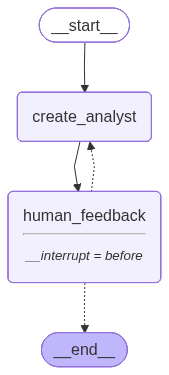

In [48]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [49]:
topic = "the benefits of adopting Langgraph as an agent framework"

In [50]:
max_analysts = 4

In [51]:
thread =  {"configurable":{"thread_id":1}}

In [52]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  
            
        

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Emily Chen
Affiliation: Institute of Advanced AI Systems
Role: AI Framework Specialist
Description: Dr. Chen focuses on the technical advantages of adopting Langgraph as an agent framework. Her primary interest lies in how Langgraph enhances modularity and scalability in AI systems, making it easier for developers to build and maintain complex agent-based applications.
--------------------------------------------------
Name: Raj Patel
Affiliation: Tech Innovations Inc.
Role: Enterprise Solutions Consultant
Description: Raj is concerned with the practical business benefits of integrating Langgraph into existing enterprise systems. He explores how Langgraph can improve operational efficiency and reduce costs by streamlining the development process and enabling more robust automation solutions.
--------------------------------------------------
Name: Lisa Gomez
Affiliation: Global AI Ethics Consortium
Role: AI Ethics and Governance Expert
Description: Lisa examines the ethical i

In [53]:
state = graph.get_state(thread)

In [54]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'analysts': [Analyst(name='Dr. Emily Chen', role='AI Framework Specialist', affiliation='Institute of Advanced AI Systems', description='Dr. Chen focuses on the technical advantages of adopting Langgraph as an agent framework. Her primary interest lies in how Langgraph enhances modularity and scalability in AI systems, making it easier for developers to build and maintain complex agent-based applications.'), Analyst(name='Raj Patel', role='Enterprise Solutions Consultant', affiliation='Tech Innovations Inc.', description='Raj is concerned with the practical business benefits of integrating Langgraph into existing enterprise systems. He explores how Langgraph can improve operational efficiency and reduce costs by streamlining the development process and enabling more robust automation solutions.'), Analyst(name='Lisa Gomez', role='AI Ethics and Governance Expert', affiliation='G

In [55]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4,
 'analysts': [Analyst(name='Dr. Emily Chen', role='AI Framework Specialist', affiliation='Institute of Advanced AI Systems', description='Dr. Chen focuses on the technical advantages of adopting Langgraph as an agent framework. Her primary interest lies in how Langgraph enhances modularity and scalability in AI systems, making it easier for developers to build and maintain complex agent-based applications.'),
  Analyst(name='Raj Patel', role='Enterprise Solutions Consultant', affiliation='Tech Innovations Inc.', description='Raj is concerned with the practical business benefits of integrating Langgraph into existing enterprise systems. He explores how Langgraph can improve operational efficiency and reduce costs by streamlining the development process and enabling more robust automation solutions.'),
  Analyst(name='Lisa Gomez', role='AI Ethics and Governance Expert', affiliation='Global AI Ethics

In [56]:
state.next

('human_feedback',)

In [90]:
# memory.storage

In [57]:
memory.storage.items()

dict_items([('1', defaultdict(<class 'dict'>, {'': {'1f108af5-ffe4-6f51-bfff-5159554b8bef': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2026-02-13T07:41:14.799700+00:00\xa2id\xd9$1f108af5-ffe4-6f51-bfff-5159554b8bef\xb0channel_versions\x81\xa9__start__\xd9400000000000000000000000000000001.0.37102812579346056\xadversions_seen\x81\xa9__input__\x80\xb0updated_channels\x91\xa9__start__'), ('msgpack', b'\x83\xa6source\xa5input\xa4step\xff\xa7parents\x80'), None), '1f108af5-fff3-69ae-8000-c658364e540e': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2026-02-13T07:41:14.805700+00:00\xa2id\xd9$1f108af5-fff3-69ae-8000-c658364e540e\xb0channel_versions\x84\xa9__start__\xd9300000000000000000000000000000002.0.2901151373603519\xa5topic\xd9300000000000000000000000000000002.0.2901151373603519\xacmax_analysts\xd9300000000000000000000000000000002.0.2901151373603519\xb8branch:to:create_analyst\xd9300000000000000000000000000000002.0.2901151373603519\xadversions_seen\x82\xa9__input__\x80\xa9__start__\x81\xa9__start__\x

In [91]:
# import msgpack

# for thread_id, ns_dict in memory.storage.items():
#     print(f"\n Thread ID: {thread_id}")
    
#     # ns_dict = defaultdict(dict, {'': {...}})
#     for ns, ckpts in ns_dict.items():
#         print(f"  Namespace: '{ns}'")
        
#         # ckpts = dict of {checkpoint_id: (packed_values, packed_metadata, parent_id)}
#         for ckpt_id, (packed_values, packed_metadata, parent_id) in ckpts.items():
#             print(f"    Checkpoint ID: {ckpt_id}")
            
#             # Decode msgpack binary
#             values = msgpack.unpackb(packed_values[1], raw=False)
#             meta = msgpack.unpackb(packed_metadata[1], raw=False)
            
#             print(f"    Values keys: {list(values.keys())}")
#             print(f"    Parent ID: {parent_id}")
#             print(f"    Metadata: {meta}")
#             print("-" * 80)


In [58]:
state.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f108af6-a6f2-6f9e-8001-1feaa5416920'}}

In [59]:
graph.update_state(thread,
                   {"human_analyst_feedback":"add something from the startup perspective and focus on the latest enterprise application"},as_node="human_feedback"
                   )

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f108af8-8631-6ba7-8002-5c1822ad77f2'}}

In [60]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Chen
Affiliation: Institute of Advanced AI Systems
Role: AI Framework Specialist
Description: Dr. Chen focuses on the technical advantages of adopting Langgraph as an agent framework. Her primary interest lies in how Langgraph enhances modularity and scalability in AI systems, making it easier for developers to build and maintain complex agent-based applications.
--------------------------------------------------
Name: Raj Patel
Affiliation: Tech Innovations Inc.
Role: Enterprise Solutions Consultant
Description: Raj is concerned with the practical business benefits of integrating Langgraph into existing enterprise systems. He explores how Langgraph can improve operational efficiency and reduce costs by streamlining the development process and enabling more robust automation solutions.
--------------------------------------------------
Name: Lisa Gomez
Affiliation: Global AI Ethics Consortium
Role: AI Ethics and Governance Expert
Description: Lisa examines the ethical i

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Sophia Tran
Affiliation: Tech Innovators Network
Role: Startup Ecosystem Analyst
Description: Sophia focuses on the impact of adopting new technologies like Langgraph within startup environments. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance scalability for emerging companies. Her analysis often includes case studies of startups that have successfully integrated Langgraph into their frameworks.
--------------------------------------------------
Name: Michael Chen
Affiliation: Global Enterprise Solutions
Role: Enterprise Application Specialist
Description: Michael specializes in the latest enterprise applications and how they can be optimized using frameworks like Langgraph. He examines the integration of Langgraph in large-scale operations, focusing on its ability to improve efficiency, data management, and cross-departmental communication. His insights are geared towards CIOs and IT managers looking to modernize their tech s

In [61]:
state = graph.get_state(thread)

In [62]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application', 'analysts': [Analyst(name='Sophia Tran', role='Startup Ecosystem Analyst', affiliation='Tech Innovators Network', description='Sophia focuses on the impact of adopting new technologies like Langgraph within startup environments. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance scalability for emerging companies. Her analysis often includes case studies of startups that have successfully integrated Langgraph into their frameworks.'), Analyst(name='Michael Chen', role='Enterprise Application Specialist', affiliation='Global Enterprise Solutions', description='Michael specializes in the latest enterprise applications and how they can be optimized using frameworks like Langgraph. He examines the integration of Lan

In [56]:
state.next

('human_feedback',)

In [57]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4,
 'human_analyst_feedback': 'add something from the startup perspective and focus on the latest enterprise application',
 'analysts': [Analyst(name='Sophia Tran', role='Startup Ecosystem Analyst', affiliation='Tech Innovators Network', description='Sophia focuses on the impact of adopting new technologies like Langgraph within startup environments. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance scalability for emerging companies. Her analysis often includes case studies of startups that have successfully integrated Langgraph into their frameworks.'),
  Analyst(name='Michael Chen', role='Enterprise Application Specialist', affiliation='Global Enterprise Solutions', description='Michael specializes in the latest enterprise applications and how frameworks like Langgraph can be leveraged to improve efficiency and innovation. He examines the integrat

In [99]:
# import msgpack

# def get_all_checkpoints(memory, thread_id="1"):
#     """Return all checkpoints in chronological order for a thread."""
#     checkpoints = []
#     ns_dict = memory.storage.get(thread_id, {})
#     if "" not in ns_dict:
#         return []

#     for ckpt_id, (packed_values, packed_meta, parent_id) in ns_dict[""].items():
#         values = msgpack.unpackb(packed_values[1], raw=False)
#         meta = msgpack.unpackb(packed_meta[1], raw=False)
#         checkpoints.append({
#             "id": ckpt_id,
#             "parent": parent_id,
#             "topic": values.get("topic"),
#             "feedback": values.get("human_analyst_feedback"),
#             "analyst_count": len(values.get("analysts", [])),
#             "analysts": [a.model_dump() for a in values.get("analysts", [])],
#             "step": meta.get("step"),
#             "created_at": values.get("ts", None)
#         })
#     return checkpoints

# # Fetch all
# history = get_all_checkpoints(memory)

# # Sort by step (to get chronological order)
# history = sorted(history, key=lambda x: (x["step"] or 0))

# # Display neatly
# for h in history:
#     print(f"\nSTEP {h['step']} | CHECKPOINT {h['id']}")
#     print(f"Parent: {h['parent']}")
#     print(f"Topic: {h['topic']}")
#     print(f"Feedback: {h['feedback']}")
#     print(f"Analysts generated: {h['analyst_count']}")
#     print("-"*100)


In [63]:
# If we are satisfied, then we simply supply no feedback
further_feedack = ""

In [64]:
# 1) Get the latest state (you're paused at 'human_feedback')
state = graph.get_state(thread)

# 2) Use the exact config from that state (it already has thread_id, checkpoint_ns, checkpoint_id)
cfg = state.config

In [66]:
# 3) Update feedback at the 'human_feedback' node
#    Tip: if your TypedDict says `human_analyst_feedback: str`, prefer "" (empty string) over None
graph.update_state(cfg, {"human_analyst_feedback": ""}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f108afe-b464-60a3-8006-42226210c8f2'}}

In [67]:
# 4) Verify it moved to END
final_state = graph.get_state(thread)
print(final_state.next)  # should be (END,)


()


In [68]:
analysts = final_state.values.get('analysts')

In [69]:
analysts

[Analyst(name='Sophia Tran', role='Startup Ecosystem Analyst', affiliation='Tech Innovators Network', description='Sophia focuses on the impact of adopting new technologies like Langgraph within startup environments. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance scalability for emerging companies. Her analysis often includes case studies of startups that have successfully integrated Langgraph into their frameworks.'),
 Analyst(name='Michael Chen', role='Enterprise Application Specialist', affiliation='Global Enterprise Solutions', description='Michael specializes in the latest enterprise applications and how they can be optimized using frameworks like Langgraph. He examines the integration of Langgraph in large-scale operations, focusing on its ability to improve efficiency, data management, and cross-departmental communication. His insights are geared towards CIOs and IT managers looking to modernize their tech stacks.'),
 Analyst

In [70]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Sophia Tran
Affiliation: Tech Innovators Network
Role: Startup Ecosystem Analyst
Description: Sophia focuses on the impact of adopting new technologies like Langgraph within startup environments. She is particularly interested in how Langgraph can streamline operations, reduce costs, and enhance scalability for emerging companies. Her analysis often includes case studies of startups that have successfully integrated Langgraph into their frameworks.
--------------------------------------------------
Name: Michael Chen
Affiliation: Global Enterprise Solutions
Role: Enterprise Application Specialist
Description: Michael specializes in the latest enterprise applications and how they can be optimized using frameworks like Langgraph. He examines the integration of Langgraph in large-scale operations, focusing on its ability to improve efficiency, data management, and cross-departmental communication. His insights are geared towards CIOs and IT managers looking to modernize their tech s

In [65]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="LangGraph").load()
print(docs[0].page_content[:500])

LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 


## Second Workflow

In [66]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [69]:
from dotenv import load_dotenv
load_dotenv()
import os
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [70]:
tavily_search = TavilySearchResults(tavily_api_key=tavily_api_key)

In [71]:
tavily_search.invoke("langgraph")

[{'title': 'LangGraph: A Framework for Building Stateful Multi-Agent LLM ...',
  'url': 'https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03',
  'content': '> LangGraph is a powerful Python library designed for constructing stateful, multi-actor applications with Large Language Models (LLMs). It extends the capabilities of LangChain Expression Language (LCEL) while specifically addressing limitations in existing frameworks for agent development. As a specialized tool for creating complex LLM applications, LangGraph provides a structured approach to building sophisticated workflows that require cyclical processing patterns. [...] LangGraph represents a significant advancement in the toolkit available for developing sophisticated LLM applications, particularly those involving agent-like behaviors and multi-agent coordination. By extending LangChain with support for cyclical workflows and robust state management, it addresses k

In [72]:
from langchain_community.document_loaders import WikipediaLoader

docs = WikipediaLoader(query="LangGraph").load()
print(docs[0].page_content[:500])

LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 


LangChain is a software framework that helps facilitate the integration of large language models (LLMs) into applications. As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.


== History ==
LangChain was launched in October 2022 as an open source project by Harrison Chase, while working at machine learning startup Robust Intelligence. In April 2023, 

In [73]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [74]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

In [76]:
analyst

Analyst(name="Liam O'Reilly", role='Business Strategy Consultant', affiliation='FutureTech Consulting', description='Liam advises businesses on strategic technology adoption. He focuses on how Langgraph can be a game-changer in aligning business strategies with technological advancements. His insights include the long-term benefits of adopting Langgraph, such as improved customer engagement and competitive advantage in the market.')

In [75]:
print(analyst.persona)

Name: Liam O'Reilly
Role: Business Strategy Consultant
Affiliation: FutureTech Consulting
Description: Liam advises businesses on strategic technology adoption. He focuses on how Langgraph can be a game-changer in aligning business strategies with technological advancements. His insights include the long-term benefits of adopting Langgraph, such as improved customer engagement and competitive advantage in the market.



In [175]:
question_instructions.format(goals = analyst.persona)

'You are an analyst tasked with interviewing an expert to learn about a specific topic. \n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n\n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals: Name: Michael Chen\nRole: Business Strategy Consultant\nAffiliation: FutureTech Consulting\nDescription: Michael analyzes the strategic implications of adopting Langgraph for businesses. He focuses on how the framework can drive innovation, support digital transformation initiatives, and align with long-term business goals.\n\n\nBegin by introducing yourself using a name that fits your persona, and then ask your question.\n\nContinue to ask questions to drill down and refine your understanding of the topic.\n\nWhen you are satisfied with your understanding, complete the interview with: "Thank you

In [ ]:
'You are an analyst tasked with interviewing an expert to learn about a specific topic. \n\nYour goal is boil down to interesting and specific insights related to your topic.\n\n1. Interesting: Insights that people will find surprising or non-obvious.\n\n2. Specific: Insights that avoid generalities and include specific examples from the expert.\n\nHere is your topic of focus and set of goals: Name: Michael Chen\nRole: Business Strategy Consultant\nAffiliation: FutureTech Consulting\nDescription: Michael analyzes the strategic implications of adopting Langgraph for businesses. He focuses on how the framework can drive innovation, support digital transformation initiatives, and align with long-term business goals.\n\n\nBegin by introducing yourself using a name that fits your persona, and then ask your question.\n\nContinue to ask questions to drill down and refine your understanding of the topic.\n\nWhen you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"\n\nRemember to stay in character throughout your response, reflecting the persona and goals provided to you.'

In [81]:
def generation_question(state:InterviewState):
    """Node to generate the questions"""
    
    #get state
    analyst = state["analyst"]
    messages = state["messages"]
    
    #generate the question
    system_message = question_instructions.format(goals = analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
    
    #returen the question through state
    return {"messages":[question]}

In [245]:
class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

In [82]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],"messages":[HumanMessage(content="hi do the proper search according to the experties")]}

In [83]:
state

{'max_num_turns': 2,
 'context': [],
 'analyst': Analyst(name="Liam O'Reilly", role='Business Strategy Consultant', affiliation='FutureTech Consulting', description='Liam advises businesses on strategic technology adoption. He focuses on how Langgraph can be a game-changer in aligning business strategies with technological advancements. His insights include the long-term benefits of adopting Langgraph, such as improved customer engagement and competitive advantage in the market.'),
 'interview': '',
 'section': [],
 'messages': [HumanMessage(content='hi do the proper search according to the experties', additional_kwargs={}, response_metadata={})]}

In [84]:
result = generation_question(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [202]:
result

{'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reaso

In [85]:
print(result["messages"][0].content)

Hello, I'm Alex Carter, a technology journalist with a keen interest in how businesses can leverage emerging technologies for strategic advantage. I'm excited to learn more about your expertise in strategic technology adoption, particularly with Langgraph. 

To start, could you explain what Langgraph is and why it stands out as a tool for aligning business strategies with technological advancements?


In [86]:
from langchain_core.messages import get_buffer_string

In [87]:
# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation. 
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query""")

In [88]:
def search_web(state:InterviewState):
    """
    Retrieve data from the web
    """
    structure_llm = llm.with_structured_output(SearchQuery)
    search_query = structure_llm.invoke([search_instructions]+state["messages"])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)
    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [208]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [89]:
result = search_web(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [90]:
print(result["context"][0])

<Document href="https://www.productboard.com/blog/product-launch-strategy-a-comprehensive-guide-for-success/"/>
Here are five essential stages (with steps) to guide you through the process of creating an effective product launch strategy.

#### Market Research and Analysis

 Conduct thorough market research to understand the industry, target audience, and competitive landscape.
 Identify market trends, customer needs, and potential gaps in the market.
 Analyze competitor product launches to learn from successes and failures.

#### Define Your Target Audience [...] ## Tactics to Creating a Successful Product Launch Strategy

Understanding the market and target audience, crafting a compelling value proposition, strategically positioning the product, and developing clear and cohesive messaging: four steps to success, when built on the foundation of a thoughtful and well-rounded plan.

### 1. Pre-Launch Activities [...] Before the official introduction of the product, the goal is to build 

In [91]:
def search_wikipedia(state:InterviewState):
    """
    Retrieve data from wiki
    """
    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    print("*******************************")
    print(search_query)
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 
    

In [225]:
state = {"max_num_turns":2,"context":[],"analyst":analyst,"interview":"","section":[],'messages': [AIMessage(content="Hello, my name is Alex Thompson, and I'm an analyst interested in understanding the strategic implications of adopting Langgraph for businesses. I'm particularly keen on how this framework can drive innovation and support digital transformation initiatives. Thank you for taking the time to speak with me today, Michael. \n\nTo start, could you explain what Langgraph is and why it's becoming a significant consideration for businesses looking to innovate?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 79, 'prompt_tokens': 224, 'total_tokens': 303, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CPRmMT7ufhFyYLhMtNpeguI9W2y6O', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--827b799b-ccb9-422c-a444-402d7ddc4550-0', usage_metadata={'input_tokens': 224, 'output_tokens': 79, 'total_tokens': 303, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [92]:
result = search_wikipedia(state)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='current trends in AI and machine learning 2023'


In [93]:
search_docs = WikipediaLoader(query='Langgraph framework benefits',load_all_available_meta=True).load()

In [241]:
search_docs

[]

In [227]:
result

{'context': ['']}

In [94]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

In [95]:
def generate_answer(state:InterviewState):
   
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}
    

how many analyst we were doing to be create:
4

max_trun:2

means if atleast 2 expert are giving ans then we can save the result.

In [96]:
def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    
    return "ask_question"

In [97]:
def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

In [98]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

In [99]:
def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}


In [100]:
interview_builder = StateGraph(InterviewState)

In [101]:
interview_builder.add_node("ask_question",generation_question)
interview_builder.add_node("search_web",search_web)
interview_builder.add_node("search_wikipedia",search_wikipedia)
interview_builder.add_node("generate_answer",generate_answer)
interview_builder.add_node("save_interview",save_interview)
interview_builder.add_node("write_section",write_section)

In [102]:
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question","search_web")
interview_builder.add_edge("ask_question","search_wikipedia")
interview_builder.add_edge("search_web","generate_answer")
interview_builder.add_edge("search_wikipedia","generate_answer")
interview_builder.add_conditional_edges("generate_answer",
                           route_messages,
                           ["ask_question",
                            "save_interview"])
interview_builder.add_edge("save_interview","write_section")
interview_builder.add_edge("write_section",END)

In [103]:
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name = "Conduct Interview")


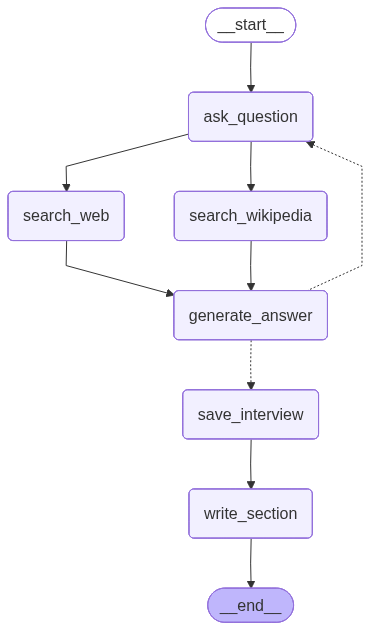

In [104]:
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [105]:
analyst

Analyst(name="Liam O'Reilly", role='Business Strategy Consultant', affiliation='FutureTech Consulting', description='Liam advises businesses on strategic technology adoption. He focuses on how Langgraph can be a game-changer in aligning business strategies with technological advancements. His insights include the long-term benefits of adopting Langgraph, such as improved customer engagement and competitive advantage in the market.')

In [106]:
analyst.persona

"Name: Liam O'Reilly\nRole: Business Strategy Consultant\nAffiliation: FutureTech Consulting\nDescription: Liam advises businesses on strategic technology adoption. He focuses on how Langgraph can be a game-changer in aligning business strategies with technological advancements. His insights include the long-term benefits of adopting Langgraph, such as improved customer engagement and competitive advantage in the market.\n"

In [107]:
thread = {"configurable": {"thread_id": "1"}}

In [108]:
from IPython.display import Markdown

In [109]:
messages = [HumanMessage("So you said you were writing an article on Langchain?")]

In [110]:
interview = interview_graph.invoke({"analyst": analyst, "messages": messages, "max_num_turns": 2}, thread)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='Langgraph impact on business strategy customer engagement'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


*******************************
search_query='companies successfully using Langgraph for competitive advantage'


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [111]:
Markdown(interview['sections'][0])

## Langgraph: A Strategic Game-Changer in Business Technology

### Summary

In the rapidly evolving landscape of business technology, Langgraph emerges as a pivotal tool for aligning business strategies with technological advancements. As businesses strive to enhance customer engagement and maintain a competitive edge, Langgraph offers a robust framework for integrating AI-driven automation into various business processes. This report delves into the transformative potential of Langgraph, highlighting its role in improving customer engagement and operational efficiency.

Langgraph combines language processing with graph databases, enabling AI agents to enhance decision-making and predictions in business operations. This technology is particularly beneficial in industries like mortgage services, where it allows providers to analyze vast amounts of customer data to predict needs and preferences, thereby offering tailored products and advice [1]. This capability significantly enhances customer satisfaction and engagement, setting a new standard for customer experience in the industry.

One of the most novel aspects of Langgraph is its ability to automate complex tasks through a structured, graph-based approach. This method involves clearly specifying individual agents and their transition probabilities, making it suitable for a controlled and clearly defined flow of events [2]. By leveraging this technology, businesses can enhance their overall process automation, leading to improved operational success and innovation.

Langgraph's impact extends beyond customer engagement. It also plays a crucial role in streamlining business processes and improving efficiency. For instance, in logistics operations, Langgraph has been shown to save significant time and resources, with some companies reporting average annual cost savings of $1.2 million [3]. Additionally, the technology supports faster time-to-market for products in fintech and healthtech sectors, demonstrating its versatility across different industries.

Furthermore, Langgraph's framework for building agent-based systems is being utilized in various applications, such as robotics, autonomous vehicles, and video games [4]. This adaptability makes it a valuable asset for businesses looking to innovate and stay ahead of the competition.

In conclusion, Langgraph represents a strategic game-changer for businesses seeking to align their strategies with technological advancements. Its ability to enhance customer engagement, streamline processes, and support innovation positions it as a critical tool for achieving long-term business success.

### Sources
[1] https://www.raiaai.com/blogs/langgraph-in-mortgage-using-ai-agents-revolutionizing-business-operations-and-customer-engagement  
[2] https://walkingtreetech.medium.com/empowering-virtual-sales-agents-with-ai-driven-automation-using-langgraph-897eda7159d2  
[3] https://kanerika.com/blogs/langchain-vs-langgraph/  
[4] https://www.ibm.com/think/topics/langgraph  

## third Workflow